In [1]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima

# for Model Training
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import itertools
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holt-Winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt 

# for Ensemble Learning
from sklearn.ensemble import VotingRegressor

In [2]:
df = pd.read_csv('../datasets/cleaned_orders.csv')
print(df.dtypes)
df.head(2)

customer_id                               int64
order_date                               object
order_time                               object
item_id                                  object
item_quantity                             int64
item_price                              float64
item_discount_raw                       float64
item_discount_percentage                float64
item_disc_bins_item_disc_null             int64
item_disc_bins_item_disc_sub_twenty       int64
item_disc_bins_item_disc_sub_forty        int64
item_disc_bins_item_disc_sub_sixty        int64
item_disc_bins_item_disc_sub_eighty       int64
item_disc_bins_item_disc_sub_hundred      int64
dtype: object


,customer_id,order_date,order_time,item_id,item_quantity,item_price,item_discount_raw,item_discount_percentage,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
0,0,2022-04-29,18:29:49,Arzuaga blanco,1,49.0,0.0,0.0,1,0,0,0,0,0
1,0,2022-04-29,18:29:49,Arzuaga reserva,1,94.0,0.0,0.0,1,0,0,0,0,0


In [3]:
pd.set_option('display.max_columns', None)
df.head(10)

,customer_id,order_date,order_time,item_id,item_quantity,item_price,item_discount_raw,item_discount_percentage,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
0,0,2022-04-29,18:29:49,Arzuaga blanco,1,49.0,0.0,0.0,1,0,0,0,0,0
1,0,2022-04-29,18:29:49,Arzuaga reserva,1,94.0,0.0,0.0,1,0,0,0,0,0
2,1,2022-04-22,18:08:59,Eclisse,1,51.0,0.0,0.0,1,0,0,0,0,0
3,1,2022-04-22,18:08:59,Refosco,2,62.0,0.0,0.0,1,0,0,0,0,0
4,2,2022-05-29,19:37:45,Wine Ambassador Series: Portugal - 1700 - 1800,1,39.0,0.0,0.0,1,0,0,0,0,0
5,3,2023-07-20,17:00:28,Ziereisen Blauer Spatburgunder 2017,1,50.0,0.0,0.0,1,0,0,0,0,0
6,3,2023-07-20,17:00:28,Corte Moschina I Tarai 2020,1,44.0,0.0,0.0,1,0,0,0,0,0
7,3,2023-07-20,17:00:28,Cascina Chicco Birbet NV,1,32.0,0.0,0.0,1,0,0,0,0,0
8,4,2023-06-03,16:06:32,"Wine Ambassador Series: Spier Winery, Stellenb...",2,29.0,0.0,0.0,1,0,0,0,0,0
9,5,2022-01-22,05:52:45,Luca Old Vine Malbec 2017,2,70.9,0.0,0.0,1,0,0,0,0,0


# Let's try only with 1 product, very simple model

In [4]:
df.columns

Index(['customer_id', 'order_date', 'order_time', 'item_id', 'item_quantity',
       'item_price', 'item_discount_raw', 'item_discount_percentage',
       'item_disc_bins_item_disc_null', 'item_disc_bins_item_disc_sub_twenty',
       'item_disc_bins_item_disc_sub_forty',
       'item_disc_bins_item_disc_sub_sixty',
       'item_disc_bins_item_disc_sub_eighty',
       'item_disc_bins_item_disc_sub_hundred'],
      dtype='object')

In [5]:
grouped = df[['order_date', 'item_id',
              'item_quantity']]

In [6]:
groupedbyitem = grouped.groupby('item_id', group_keys=True).apply(lambda x:x)


In [7]:
groupedbyitem['item_id'].value_counts()

Glassware                                  728
Wine Virgin                                325
Rara Neagră de Purcari 2020                110
Wine Nut                                    86
Puchang Beichun 2015                        81
                                          ... 
Chersegi furmint                             1
Creation Estate Reserve Pinot Noir 2019      1
Vinden Wines Reserve Semillon 2017           1
Adler Pinot grigio                           1
Dalmatia Babic                               1
Name: item_id, Length: 4481, dtype: int64

In [8]:
sample = groupedbyitem[groupedbyitem['item_id']=='Rara Neagră de Purcari 2020']

In [9]:
sample = sample.groupby('order_date')['item_quantity'].sum().reset_index()

In [10]:
sample

,order_date,item_quantity
0,2022-04-08,2
1,2022-04-13,3
2,2022-04-15,1
3,2022-04-16,1
4,2022-04-17,1
...,...,...
84,2023-06-27,1
85,2023-07-04,1
86,2023-07-08,1
87,2023-07-12,1


In [11]:
sample['order_date'] = pd.to_datetime(sample['order_date'])
sample = sample.set_index('order_date')

In [12]:
sample

,item_quantity
order_date,
2022-04-08,2
2022-04-13,3
2022-04-15,1
2022-04-16,1
2022-04-17,1
...,...
2023-06-27,1
2023-07-04,1
2023-07-08,1


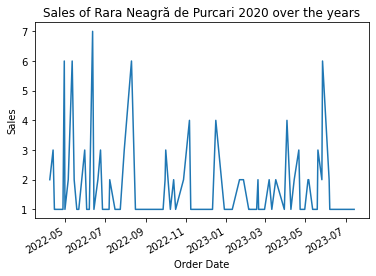

In [13]:
sample['item_quantity'].plot()
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Sales of Rara Neagră de Purcari 2020 over the years')
plt.show()

In [14]:
monthly_sales = pd.DataFrame()

monthly_sales['sales'] = sample['item_quantity'].resample('MS').mean()

In [15]:
monthly_sales

,sales
order_date,
2022-04-01,2.000000
2022-05-01,2.285714
2022-06-01,2.125000
2022-07-01,1.428571
2022-08-01,3.500000
2022-09-01,1.200000
2022-10-01,1.800000
2022-11-01,1.750000
2022-12-01,1.600000


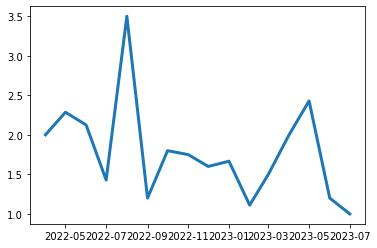

In [16]:
#plot weekly sales data
plt.plot(monthly_sales.index, monthly_sales.sales, linewidth=3)

In [17]:
x = monthly_sales.index
y = monthly_sales.sales

In [18]:
x

DatetimeIndex(['2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01'],
              dtype='datetime64[ns]', name='order_date', freq='MS')

In [19]:
y

order_date
2022-04-01    2.000000
2022-05-01    2.285714
2022-06-01    2.125000
2022-07-01    1.428571
2022-08-01    3.500000
2022-09-01    1.200000
2022-10-01    1.800000
2022-11-01    1.750000
2022-12-01    1.600000
2023-01-01    1.666667
2023-02-01    1.111111
2023-03-01    1.500000
2023-04-01    2.000000
2023-05-01    2.428571
2023-06-01    1.200000
2023-07-01    1.000000
Freq: MS, Name: sales, dtype: float64

# Training Time

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 69, shuffle=False)

In [21]:
y_train

order_date
2022-04-01    2.000000
2022-05-01    2.285714
2022-06-01    2.125000
2022-07-01    1.428571
2022-08-01    3.500000
2022-09-01    1.200000
2022-10-01    1.800000
2022-11-01    1.750000
2022-12-01    1.600000
2023-01-01    1.666667
2023-02-01    1.111111
2023-03-01    1.500000
Freq: MS, Name: sales, dtype: float64

In [22]:
x_train

DatetimeIndex(['2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', name='order_date', freq=None)

In [23]:
auto_arima(y_train, test='adf',seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=27385.605, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=43.576, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=37.230, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=33.124, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=33.078, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=31.752, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=33.427, Time=0.06 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]          
Total fit time: 0.467 seconds


ARIMA(order=(4, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [24]:
auto_arima(y,test='adf',       # use adftest to find optimal 'd'
                       # maximum p and q
                                 # frequency of series
                       # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=56.858, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=48.484, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=45.636, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=46.296, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=47.531, Time=0.02 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.407 seconds


ARIMA(order=(2, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [25]:
model_arima = ARIMA(y_train, order=(1,1,1)).fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -10.503
Date:                Thu, 07 Sep 2023   AIC                             27.007
Time:                        13:49:11   BIC                             28.201
Sample:                    04-01-2022   HQIC                            26.254
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4968      0.310     -1.602      0.109      -1.105       0.111
ma.L1         -0.5542      0.765     -0.724      0.469      -2.054       0.946
sigma2         0.3565      0.286      1.245      0.213      -0.205       0.918
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                 5.75
Prob(Q):                              0.22   Prob(JB):                         0.06
Heteroskedasticity (H):               0.24   Skew:                             1.48
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
pred_arima = model_arima.predict(start=len(y_train), end=(len(y)-1),dynamic=True)
pred_arima

2023-04-01    1.433956
2023-05-01    1.466764
2023-06-01    1.450466
2023-07-01    1.458563
Freq: MS, Name: predicted_mean, dtype: float64

In [27]:
y_test

order_date
2023-04-01    2.000000
2023-05-01    2.428571
2023-06-01    1.200000
2023-07-01    1.000000
Freq: MS, Name: sales, dtype: float64

# Evaluate

In [28]:
mape_arima = mean_absolute_percentage_error(y_test, pred_arima)
rmse_arima = mean_squared_error(y_test, pred_arima, squared=False)

print('MAPE SARIMAX: %f' %mape_arima)
print('RMSE SARIMAX: %f' %rmse_arima)

MAPE SARIMAX: 0.336586
RMSE SARIMAX: 0.616136


<AxesSubplot:xlabel='order_date'>

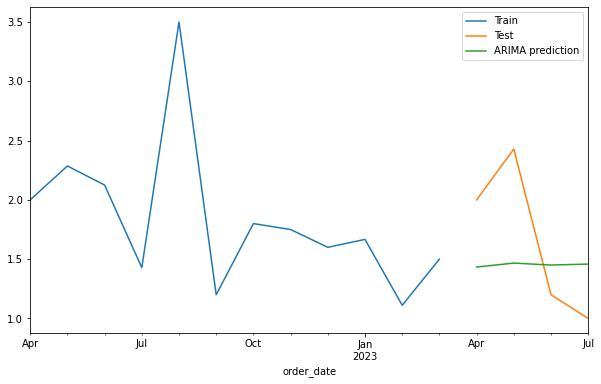

In [29]:
y_train.plot(legend=True, label='Train', figsize=(10,6))

y_test.plot(legend=True, label= 'Test')

pred_arima.plot(legend=True, label='ARIMA prediction')

# Seasonal ARIMA

In [30]:
model_sarimax = sm.tsa.statespace.SARIMAX(y_train,order=(1, 1, 1),seasonal_order=(1,1,1,12))

results_sarimax = model_sarimax.fit()
results_sarimax.summary()

C:\Users\Kevan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Kevan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Kevan\anaconda3\lib\site-packages\statsmodels\tools\eval_measures.py:406: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
C:\Users\Kevan\anaconda3\lib\site-packages\statsmodels\tools\eval_measures.py:431: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
C:\Users\Kevan\anaconda3\lib\site-packa

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                   12
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Thu, 07 Sep 2023   AIC                             10.000
Time:                                    13:49:11   BIC                                nan
Sample:                                04-01-2022   HQIC                               nan
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L12            0         -0        nan        nan           0           0
ma.S.L12            0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [31]:
pred_sarimax = results_sarimax.predict(start= len(y_train), end= (len(y)-1),dynamic=True)
pred_sarimax

2023-04-01    2.500000
2023-05-01    2.785715
2023-06-01    2.625000
2023-07-01    1.928572
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='order_date'>

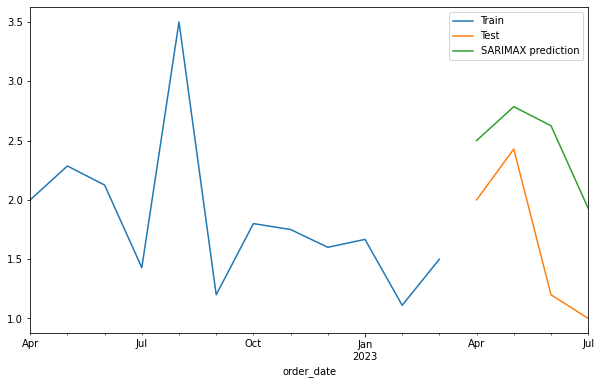

In [32]:
y_train.plot(legend=True, label='Train', figsize=(10,6))

y_test.plot(legend=True, label= 'Test')

pred_sarimax.plot(legend=True, label='SARIMAX prediction')

In [33]:
mape_sarimax = mean_absolute_percentage_error(y_test, pred_sarimax)
rmse_sarimax = mean_squared_error(y_test, pred_sarimax, squared=False)

print('MAPE SARIMAX: %f' %mape_sarimax)
print('RMSE SARIMAX: %f' %rmse_sarimax)

MAPE SARIMAX: 0.628283
RMSE SARIMAX: 0.904216


# Predicting future sales

In [34]:
future_sale = results_sarimax.predict(start= len(y), end=(len(y)+12))
future_sale

2023-08-01    4.000000
2023-09-01    1.700000
2023-10-01    2.300000
2023-11-01    2.250000
2023-12-01    2.100000
2024-01-01    2.166667
2024-02-01    1.611112
2024-03-01    2.000000
2024-04-01    3.000001
2024-05-01    3.285715
2024-06-01    3.125001
2024-07-01    2.428572
2024-08-01    4.500001
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='order_date'>

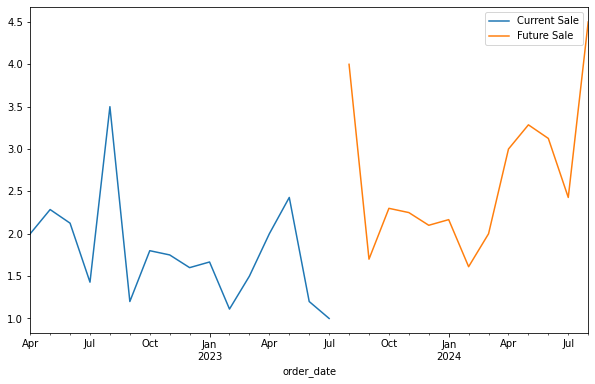

In [35]:
y.plot(legend=True, label='Current Sale', figsize=(10,6))

future_sale.plot(legend= True, label='Future Sale')

In [36]:
y

order_date
2022-04-01    2.000000
2022-05-01    2.285714
2022-06-01    2.125000
2022-07-01    1.428571
2022-08-01    3.500000
2022-09-01    1.200000
2022-10-01    1.800000
2022-11-01    1.750000
2022-12-01    1.600000
2023-01-01    1.666667
2023-02-01    1.111111
2023-03-01    1.500000
2023-04-01    2.000000
2023-05-01    2.428571
2023-06-01    1.200000
2023-07-01    1.000000
Freq: MS, Name: sales, dtype: float64

In [37]:
y.dtype

dtype('float64')

In [38]:
for_front_end = pd.concat([y, future_sale])
for_front_end = for_front_end.reset_index()
for_front_end = for_front_end.rename(columns={"index": "month", 0: "sales"})
for_front_end.to_csv('../datasets/demand_prediction_sarimax_sample.csv', index=False)
for_front_end

,month,sales
0,2022-04-01,2.000000
1,2022-05-01,2.285714
2,2022-06-01,2.125000
3,2022-07-01,1.428571
4,2022-08-01,3.500000
5,2022-09-01,1.200000
6,2022-10-01,1.800000
7,2022-11-01,1.750000
8,2022-12-01,1.600000
9,2023-01-01,1.666667


# Combine Both

In [39]:
pred_arima

2023-04-01    1.433956
2023-05-01    1.466764
2023-06-01    1.450466
2023-07-01    1.458563
Freq: MS, Name: predicted_mean, dtype: float64

In [40]:
pred_sarimax

2023-04-01    2.500000
2023-05-01    2.785715
2023-06-01    2.625000
2023-07-01    1.928572
Freq: MS, Name: predicted_mean, dtype: float64

In [42]:
# Initialize lists to store MSE and MAPE results
rmse_results = []
mape_results = []

# Iterate through different weight values for pred_arima
for weight in np.arange(0.1, 1.0, 0.1):
    # Calculate the weighted average of the two predictions
    weighted_average = (weight * np.array(pred_arima)) + ((1 - weight) * np.array(pred_sarimax))
    
    # Calculate MSE and MAPE
    rmse = mean_squared_error(y_test, weighted_average, squared=False)
    mape = mean_absolute_percentage_error(y_test, weighted_average)
    
    # Append results to the lists
    rmse_results.append((weight, rmse))
    mape_results.append((weight, mape))

# Print the results
print("ARIMA Weight  SARIMAX Weight  RMSE    MAPE")
for weight, mse in rmse_results:
    mape = next(mape for w, mape in mape_results if w == weight)
    print(f"{weight:.1f}            {(1 - weight):.1f}            {mse:.4f}  {mape*100:.2f}%")


ARIMA Weight  SARIMAX Weight  RMSE    MAPE
0.1            0.9            0.8204  56.52%
0.2            0.8            0.7423  50.20%
0.3            0.7            0.6717  44.68%
0.4            0.6            0.6114  41.09%
0.5            0.5            0.5647  38.32%
0.6            0.4            0.5350  37.39%
0.7            0.3            0.5254  36.45%
0.8            0.2            0.5368  35.52%
0.9            0.1            0.5681  34.59%


In [43]:
# Here we can see a 70:30 split returns the best RMSE. Let's see hows the future sales graph look like with this split

future_sales_arima = model_arima.predict(start=len(y), end=(len(y)+12))
future_sales_sarimax = results_sarimax.predict(start= len(y), end=(len(y)+12))

future_sales_arima

2023-08-01    1.454540
2023-09-01    1.456538
2023-10-01    1.455546
2023-11-01    1.456039
2023-12-01    1.455794
2024-01-01    1.455916
2024-02-01    1.455855
2024-03-01    1.455885
2024-04-01    1.455870
2024-05-01    1.455878
2024-06-01    1.455874
2024-07-01    1.455876
2024-08-01    1.455875
Freq: MS, Name: predicted_mean, dtype: float64

In [44]:
future_sales_sarimax

2023-08-01    4.000000
2023-09-01    1.700000
2023-10-01    2.300000
2023-11-01    2.250000
2023-12-01    2.100000
2024-01-01    2.166667
2024-02-01    1.611112
2024-03-01    2.000000
2024-04-01    3.000001
2024-05-01    3.285715
2024-06-01    3.125001
2024-07-01    2.428572
2024-08-01    4.500001
Freq: MS, Name: predicted_mean, dtype: float64

In [45]:
weight_arima = 0.7
future_sales_weighted = (weight_arima * future_sales_arima) + ((1 - weight_arima) * future_sales_sarimax)
future_sales_weighted

2023-08-01    2.218178
2023-09-01    1.529577
2023-10-01    1.708882
2023-11-01    1.694227
2023-12-01    1.649056
2024-01-01    1.669141
2024-02-01    1.502432
2024-03-01    1.619120
2024-04-01    1.919110
2024-05-01    2.004829
2024-06-01    1.956612
2024-07-01    1.747685
2024-08-01    2.369113
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'ARIMA:SARIMAX = 70:30 Sales Prediction')

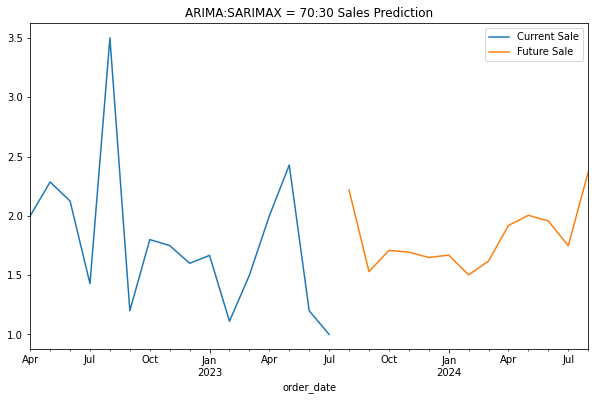

In [46]:
y.plot(legend=True, label='Current Sale', figsize=(10,6))

future_sales_weighted.plot(legend= True, label='Future Sale')

plt.title('ARIMA:SARIMAX = 70:30 Sales Prediction')

# Combine all 3

In [48]:
y_train

order_date
2022-04-01    2.000000
2022-05-01    2.285714
2022-06-01    2.125000
2022-07-01    1.428571
2022-08-01    3.500000
2022-09-01    1.200000
2022-10-01    1.800000
2022-11-01    1.750000
2022-12-01    1.600000
2023-01-01    1.666667
2023-02-01    1.111111
2023-03-01    1.500000
Freq: MS, Name: sales, dtype: float64

In [49]:
y_test

order_date
2023-04-01    2.000000
2023-05-01    2.428571
2023-06-01    1.200000
2023-07-01    1.000000
Freq: MS, Name: sales, dtype: float64

In [50]:
es_results = pd.DataFrame([], columns=['smoothing_seasonal', 'mae', 'mape'])

for x in range(1, 10, 1):
    level = x/10
    es = ExponentialSmoothing(y_train,trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_seasonal=level)
    pred_es = es.forecast(len(y_test))
    temp = [level, round(mean_squared_error(y_test, pred_es, squared=False),3), round(mean_absolute_percentage_error(test, y_pred),3)]
    es_results.loc[len(es_results)] = temp

es_results

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.